# Udacity Machine Learning Intro - Final Project

Original author: [David Banas](capn.freako@gmail.com)  
Original date:   June 16, 2017

Copyright (c) 2017 David Banas; all rights reserved World wide.

## Contents <a name="contents"/>

- [Introduction](#introduction)
- [Task 1 - Feature Selection](#task1)
- [Task 2 - Outlier Removal](#task2)
- [Initial Visual Data Review](#data_review)
    - [Some Observations in the Data](#observations)
- [Task 3 - New Feature Creation](#task3)
    - [Some Final Thoughts](#final_thoughts)
- [Task 4 - Trying Different Classifiers](#task4)
- [Task 5 - Tuning the Chosen Classifiers](#task5)
    - [Relative Feature Importance](#rel_feature_imp)
    - [Testing the Final Version](#final_test)
- [Final Questions](#final_questions)
- [Conclusion](#conclusion)


## Introduction <a name="introduction"/>

This [Jupyter notebook](http://jupyter.org) contains my solution to the *Final Project* assignment in the [Udacity](https://www.udacity.com) [Machine Learning Introduction course](https://www.udacity.com/course/intro-to-machine-learning--ud120).

The general challenge is to build a classifier, which can reliably identify a "person of interest" within the Enron data set. The starter code for this assignment comes from the *final_project/poi_id.py* file, supplied as part of the code suite used for this course. And I have copied code/comments from that file throughout this notebook.

Why create this notebook, instead of just using the supplied starter code file? Three reasons:

1. This work tends to be very iterative. And the Jupyter notebook environment is ideal for such work, allowing one to split the code into different functional blocks, each having full access to the imports, variables, etc. defined/computed in previous blocks. In this way, one needn't rerun the entire program when attempting to evaluate the effect of changing a parameter, coding approach, etc. fairly far down in the code. And this can save a lot of time.
2. It is straightforward to export one of these notebooks to HTML, which can then be made accessible by commiting/pushing to a Git repository. That way a pointer can be passed to many recipients, whom may be interested in viewing this work, without sending the notebook itself.
3. More full featured commenting/annotating of the code is possible, using the Jypyter notebook framework, than is possible with standard Python comments. Some examples of this include:
    - text formatting,
    - hyperlinking, both within this document, as well as to other Web sites, and
    - capturing of the Python interpreter output as a part of the final document.

**Notes on using this notebook**

1. This notebook file is located, on my computer, in a directory dedicated to this course, which includes the *ud120-projects* subfolder, created by expanding the source code tarball for this course. Certain file name strings in the code, below, have been changed to reflect this. Therefore, to use this notebook unmodified, you should, also, place it in your own top-level folder, and expand the tarball within that folder, as I have.


[Back to contents](#contents)

## Task 1 - Feature Selection <a name="task1"/>

In [4]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 12)

import numpy       as np
import pickle
import sys

from matplotlib     import pyplot as plt
from operator       import itemgetter

sys.path.append("ud120-projects/tools/")

from feature_format import featureFormat, targetFeatureSplit

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi',
        'salary',
        'deferral_payments',
        'total_payments',
        'bonus',
        'total_stock_value',
        'loan_advances',
        ] # You will need to use more features

### Load the dictionary containing the dataset
with open("ud120-projects/final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


[Back to contents](#contents)

## Task 2 - Outlier Removal <a name="task2"/>

In [5]:
# The data contains a TOTAL sample, which will confuse our classifier if we don't eliminate it.
data_dict.pop('TOTAL', 0)


{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

[Back to contents](#contents)

## Initial Visual Data Review <a name="data_review"/>

I found this trick, for creating a helpful matrix plot, in the O'Reilly book *Introduction to Machine Learning with Python*, by Muller & Guido.


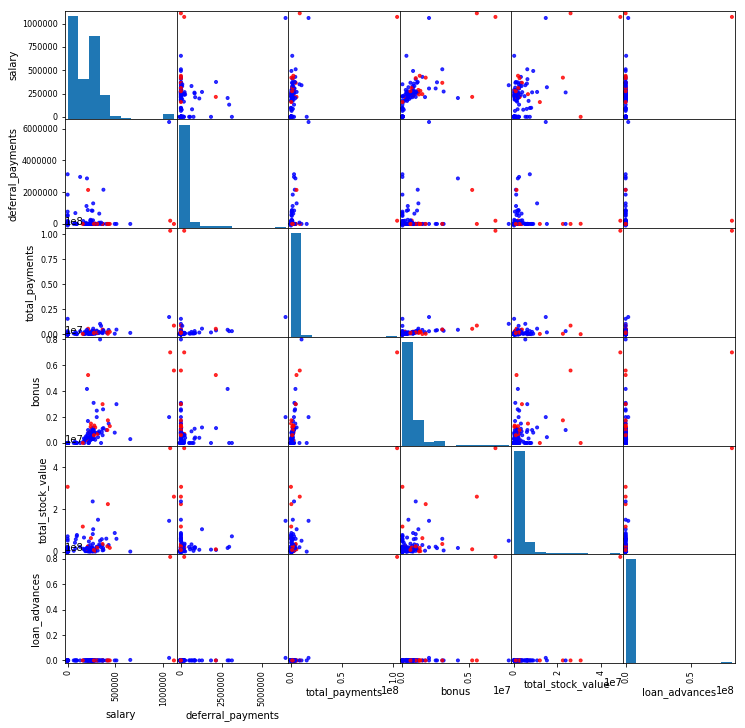

In [6]:
import pandas as pd
from matplotlib.colors import ListedColormap

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# Note: It appears that pandas.scatter_matrix doesn't quite work
#       as advertised, in the documentation. If it did, this wouldn't
#       be necessary. You could pass a colormap, instead.
palette = {0 : 'blue', 1 : 'red'}
labels_c = map(lambda x: palette[int(x)], labels)

data_frame = pd.DataFrame(features, columns=features_list[1:])
grr = pd.scatter_matrix(data_frame, alpha=0.8, c=labels_c)


In [7]:
from operator   import itemgetter

for feature in features_list[1:]:
    l = [(item[0], item[1][feature]) for item in data_dict.items() if not np.isnan(float(item[1][feature]))]
    l.sort(key=itemgetter(1), reverse=True)
    print "Top 3 values for feature, '{}': {}".format(feature, l[:3])
    

Top 3 values for feature, 'salary': [('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932)]
Top 3 values for feature, 'deferral_payments': [('FREVERT MARK A', 6426990), ('HORTON STANLEY C', 3131860), ('HUMPHREY GENE E', 2964506)]
Top 3 values for feature, 'total_payments': [('LAY KENNETH L', 103559793), ('FREVERT MARK A', 17252530), ('BHATNAGAR SANJAY', 15456290)]
Top 3 values for feature, 'bonus': [('LAVORATO JOHN J', 8000000), ('LAY KENNETH L', 7000000), ('SKILLING JEFFREY K', 5600000)]
Top 3 values for feature, 'total_stock_value': [('LAY KENNETH L', 49110078), ('HIRKO JOSEPH', 30766064), ('SKILLING JEFFREY K', 26093672)]
Top 3 values for feature, 'loan_advances': [('LAY KENNETH L', 81525000), ('FREVERT MARK A', 2000000), ('PICKERING MARK R', 400000)]


### Some observations in the data <a name="observations"/>

1. The *loan_advances* feature seems pretty useless; Kenneth Lay clearly stands apart from the rest of the pack, and there isn't much differentiation between the others. I believe this is what our instructors referred to as a "signature" feature, and I recall them eliminating such features in one of the lessons. So, I will remove this feature, before proceeding.
2. The *total_payments* feature is similarly bimodal, although not to the degree of the *loan_advances* feature. I will remove it, also.


In [8]:
for feature in ['loan_advances', 'total_payments']:
    features_list.remove(feature)

[Back to contents](#contents)

## Task 3 - New Feature Creation <a name="task3"/>

I decided to create a new feature, by multiplying the following 4 features together:

- expenses
- shared_receipt_with_poi
- from_this_person_to_poi
- from_poi_to_this_person

My reasoning for this is as follows: If there is someone, whom is in constant e-mail contact with POIs, and is also racking up large expenses, then perhaps that person is some sort of "dark lieutenant" out taking care of the dirty work that the executives need to keep a distance from.

I chose multiplication, as opposed to addition, for two reasons:
- It obviates the need for doing feature scaling, before combining.
- It more drastically accentuates cases with large values in all constituent features.

I check for correlation between any pair of constituent features, using the same scatter matrix plotting technique, as above, before committing to this new feature, because forging a new feature out of highly correlated constitutents is useless. (Consider multiplying a feature by itself. You wouldn't gain any information. In fact, if the original feature contains both positive and negative values, you'll lose information!)

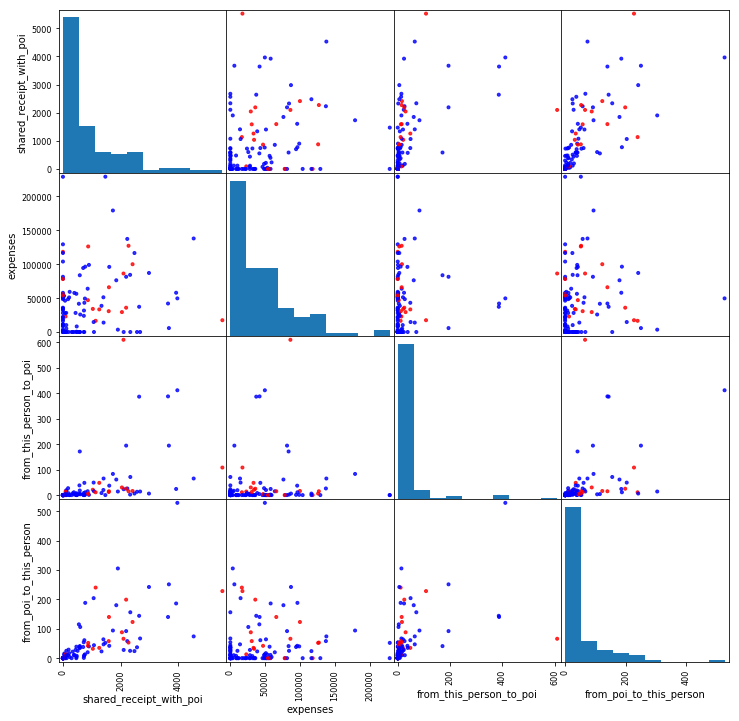

In [9]:
constituent_features_list = ['poi',
        'shared_receipt_with_poi',
        'expenses',
        'from_this_person_to_poi',
        'from_poi_to_this_person',
        ]

new_data = featureFormat(data_dict, constituent_features_list)
new_labels, new_features = targetFeatureSplit(new_data)
new_labels_c = map(lambda x: palette[int(x)], new_labels)

new_data_frame = pd.DataFrame(new_features, columns=constituent_features_list[1:])
grr = pd.scatter_matrix(new_data_frame, alpha=0.8, c=new_labels_c)


And, seeing no highly correlated pairs, I press on with my new feature creation, and take a look at the final result.

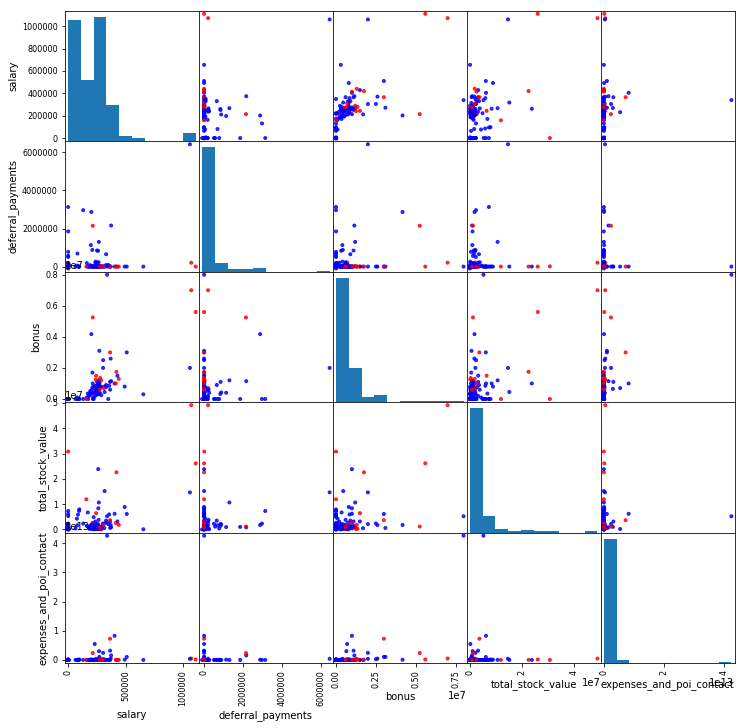

In [10]:
for key in data_dict.keys():
    features_dict = data_dict[key]
    res = 1
    for subkey in constituent_features_list[1:]:
        x = features_dict[subkey]
        if(np.isnan(float(x))):
            res = 0
        else:
            res *= x
    data_dict[key]['expenses_and_poi_contact'] = res

features_list.append('expenses_and_poi_contact')

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

labels_c = map(lambda x: palette[int(x)], labels)

data_frame = pd.DataFrame(features, columns=features_list[1:])
grr = pd.scatter_matrix(data_frame, alpha=0.8, c=labels_c)


In [11]:
for feature in ['expenses_and_poi_contact']:
    l = [(item[0], item[1][feature]) for item in data_dict.items() if not np.isnan(float(item[1][feature]))]
    l.sort(key=itemgetter(1), reverse=True)
    print "Top 3 values for feature, '{}': {}".format(feature, l[:3])


Top 3 values for feature, 'expenses_and_poi_contact': [('LAVORATO JOHN J', 42591204022752), ('KEAN STEVEN J', 8271496272060), ('DELAINEY DAVID W', 7263332254332)]


### Some Final Thoughts <a name="final_thoughts"/>

This *John Lavorato* is becoming an awfully curious character. He's the clear outlier in my newly created category, which is attempting to identify "dark lieutenants", and he received the largest bonus! (You can imagine Lay rewarding a guy handsomely for getting the messy field work done, while remaining discreet.) And then there's his name: Lavorato (lavatory?) "John Lavatory"?! Let's press on and see if the data reveal any additional clues about this guy.

[Back to contents](#contents)

## Task 4 - Trying Different Classifiers <a name="task4"/>

I've decided to try the following 3 classifiers:

- SVM
- Decision Tree
- Adaboost


In [12]:
from sklearn                  import svm, tree
from sklearn.ensemble         import AdaBoostClassifier
from sklearn.metrics          import precision_score, recall_score

sys.path.append("ud120-projects/final_project/")
from tester                   import test_classifier

print "Trying the SVM classifier..."
clf = svm.SVC()
test_classifier(clf, data_dict, features_list)

print "\nTrying the Decision Tree classifier..."
clf = tree.DecisionTreeClassifier()
test_classifier(clf, data_dict, features_list)

print "Trying the AdaBoost classifier..."
clf = AdaBoostClassifier()
test_classifier(clf, data_dict, features_list)


/Users/dbanas/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Trying the SVM classifier...
Got a divide by zero when trying out: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.

Trying the Decision Tree classifier...
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.78515	Precision: 0.31341	Recall: 0.33300	F1: 0.32291	F2: 0.32889
	Total predictions: 13000	True positives:  666	False positives: 1459	False negatives: 1334	True negatives: 9541

Trying the AdaBoost classifier...
AdaBoostClassifier(algorithm='SAMME.R', base_estima

Since the *Decision Tree* classifier is already meeting the target of *precision* and *recall* both greater than 0.3, I'll go with it and see if I can improve the results.


[Back to contents](#contents)

## Task 5 - Tuning the Chosen Classifier <a name="task5"/>

Here, I'm going to try to let the machine do the work, using the grid approach from the course.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import classification_report

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, stratify=labels)

# Set the parameters by cross-validation
tuned_parameters = [
    {'criterion' : ['gini', 'entropy'],
     'splitter'  : ['best', 'random'],
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("Tuning hyper-parameters for %s:" % score)

    clf = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters,
                       scoring='%s_macro' % score)
    clf.fit(features_train, labels_train)

    print("\tBest parameters set found on development set:"),
    print(clf.best_params_)
    print("\tGrid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("\t\t%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("\tDetailed classification report:")
    y_true, y_pred = labels_test, clf.predict(features_test)
    print(classification_report(y_true, y_pred))


Tuning hyper-parameters for precision:
	Best parameters set found on development set: {'splitter': 'best', 'criterion': 'entropy'}
	Grid scores on development set:
		0.654 (+/-0.091) for {'splitter': 'best', 'criterion': 'gini'}
		0.629 (+/-0.153) for {'splitter': 'random', 'criterion': 'gini'}
		0.680 (+/-0.047) for {'splitter': 'best', 'criterion': 'entropy'}
		0.558 (+/-0.064) for {'splitter': 'random', 'criterion': 'entropy'}
	Detailed classification report:
             precision    recall  f1-score   support

        0.0       0.86      0.86      0.86        28
        1.0       0.20      0.20      0.20         5

avg / total       0.76      0.76      0.76        33

Tuning hyper-parameters for recall:
	Best parameters set found on development set: {'splitter': 'best', 'criterion': 'entropy'}
	Grid scores on development set:
		0.592 (+/-0.121) for {'splitter': 'best', 'criterion': 'gini'}
		0.687 (+/-0.240) for {'splitter': 'random', 'criterion': 'gini'}
		0.708 (+/-0.086) for {'

I note the following, in the above results:

1. When the standard deviations are taken into account, none of the four possible combinations of the *splitter* and *criterion* parameters is clearly better than the others.
2. It's interesting that tuning for *recall* yields more improvement in *precision* than in recall. I wonder if this is a clue, re: under/over-fitting.
3. The scores reported, above, are quite different than those I got, using the code in *tester.py* when choosing a classifier. I can only suppose that this has to do with the *StratifiedShuffleSplit* method of data splitting used in that code, although, I thought I was replicating that, by including the *stratify* parameter in my *train_test_split()* call, above.


[Back to contents](#contents)

### Relative Feature Importance <a name="rel_feature_imp"/>

I'm awfully curious as to how my created feature stacks up.

**Note:** After running a much simplified version of the code, below, several times manually (I was debugging the print formatting.), I noticed the relative importance of the features varying quite wildly. This made me curious, and I wanted a clearer picture of what was happening. That's why the code, below, is so complicated.

In [14]:
NUM_TRIALS = 10

for (splitter, criterion) in [(splitter, criterion)
                              for splitter  in ['random', 'best']
                              for criterion in ['gini', 'entropy']]:
    feature_importances = []
    for trial in xrange(NUM_TRIALS):
        clf = tree.DecisionTreeClassifier(splitter=splitter, criterion=criterion)
        clf.fit(features_train, labels_train)
        feature_importances.append(clf.feature_importances_)
    feature_importances = np.array(feature_importances)
    means = feature_importances.mean(axis=0)
    stdev = feature_importances.std(axis=0)
    print "Results for '{}'/'{}'".format(splitter, criterion)
    print "\t{:32s}{:8s}{:8s}".format('Feature', 'Mean', 'StdDev')
    print "\t{:48s}".format("="*48)
    i = 0
    for feature in features_list[1:]:  # 'poi' is the first element.
        print "\t{:32s} {:05.3f}   {:05.3f}".format(feature, means[i], stdev[i])
        i += 1
    print "\t{:48s}".format("_"*48)
    print "\t{:32s}         {:05.3f}".format('AVERAGE', stdev.mean())
    print


Results for 'random'/'gini'
	Feature                         Mean    StdDev  
	salary                           0.133   0.060
	deferral_payments                0.046   0.039
	bonus                            0.363   0.087
	total_stock_value                0.239   0.073
	expenses_and_poi_contact         0.220   0.078
	________________________________________________
	AVERAGE                                  0.068

Results for 'random'/'entropy'
	Feature                         Mean    StdDev  
	salary                           0.166   0.055
	deferral_payments                0.069   0.025
	bonus                            0.298   0.059
	total_stock_value                0.296   0.094
	expenses_and_poi_contact         0.171   0.086
	________________________________________________
	AVERAGE                                  0.064

Results for 'best'/'gini'
	Feature                         Mean    StdDev  
	salary                           0.164   0.046
	deferral_payments                0.009

After running the above code several times, I've noticed the following:

1. Using the 'best' option for the *splitter* parameter consistently yields lower average standard deviations.
2. The 'gini' and 'entropy' options for the *criterion* parameter seem to be roughly equivalent, although, 'entropy' seems to have a slightly lower average standard deviation, in general. And, it seems to yield a consistently lower standard deviation for my new *expenses_and_poi_contact* feature, which is very satisfying to my intuition. (I know, I know, "watch out for that!") So, I'm going to use 'best'/'entropy'.
3. The *deferral_payments* feature seems pretty useless in all four cases, above. So, I'm going to remove it.


In [15]:
features_list.remove('deferral_payments')
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)


[Back to contents](#contents)

### Testing the Final Version <a name="final_test"/>

Alright, time for the moment of truth...

In [16]:
clf = tree.DecisionTreeClassifier(splitter='best', criterion='entropy')
test_classifier(clf, data_dict, features_list)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.77738	Precision: 0.28364	Recall: 0.29300	F1: 0.28824	F2: 0.29108
	Total predictions: 13000	True positives:  586	False positives: 1480	False negatives: 1414	True negatives: 9520



D'oh! It tests worse than the default *DecisionTreeClassifier*, which uses 'best'/'gini'. Oh well, so much for intuition. ;-)

Now, even for the 'best'/'gini' case, my new feature is still scoring a very high relative importance. Let's see how it correlates, by itself, to the *POI* flag...

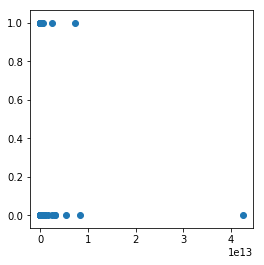

In [17]:
# zip(*(...)) = transpose(...)
ys, xs = zip(*[(item[1]['poi'], item[1]['expenses_and_poi_contact']) for item in data_dict.items()])
plt.figure(figsize=(4, 4))
plt.scatter(xs, ys)


Hmm, my new feature doesn't appear to be a very good "slicer" between POIs and non-POIs. I wonder if all I've really shown is that it doesn't make a very good first branch in a decision tree.

Let's try something a little different: let's use color to make the "POI vs. non-POI" distinction, and plot the points according to: *expenses_and_poi_contact* and *total_stock_value*, which is also a very important feature in the decision tree.

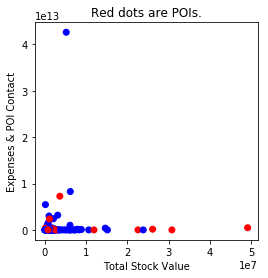

In [18]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['b', 'r'])
xs, ys, zs = zip(*[(item[1]['total_stock_value'], item[1]['expenses_and_poi_contact'], item[1]['poi'])
                   for item in data_dict.items()])
plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, c=zs, cmap=cmap)
plt.xlabel("Total Stock Value")
plt.ylabel("Expenses & POI Contact")
plt.title("Red dots are POIs.")


Hmm, it's clear that the *total_stock_value* feature makes a good first branch in the decision tree, as 3 POIs can be identified using just this feature. However, it's still not obvious to me why my new *expenses_and_poi_contact* feature is scoring so high. Let's try something: let's remove the *expenses_and_poi_contact* feature and retest the classifier.

In [19]:
features_list.remove('expenses_and_poi_contact')
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)
clf = tree.DecisionTreeClassifier()
test_classifier(clf, data_dict, features_list)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76838	Precision: 0.27897	Recall: 0.31900	F1: 0.29764	F2: 0.31010
	Total predictions: 13000	True positives:  638	False positives: 1649	False negatives: 1362	True negatives: 9351



Interesting. It looks like, while my new feature wasn't doing much for *recall*, it was helping significantly with *precision*. I think a little research into decision tree operation is in order...

Okay, I just stumbled across this: [Decision Tree Visualization](http://scikit-learn.org/stable/modules/tree.html#classification). Let's try it and see what we learn...

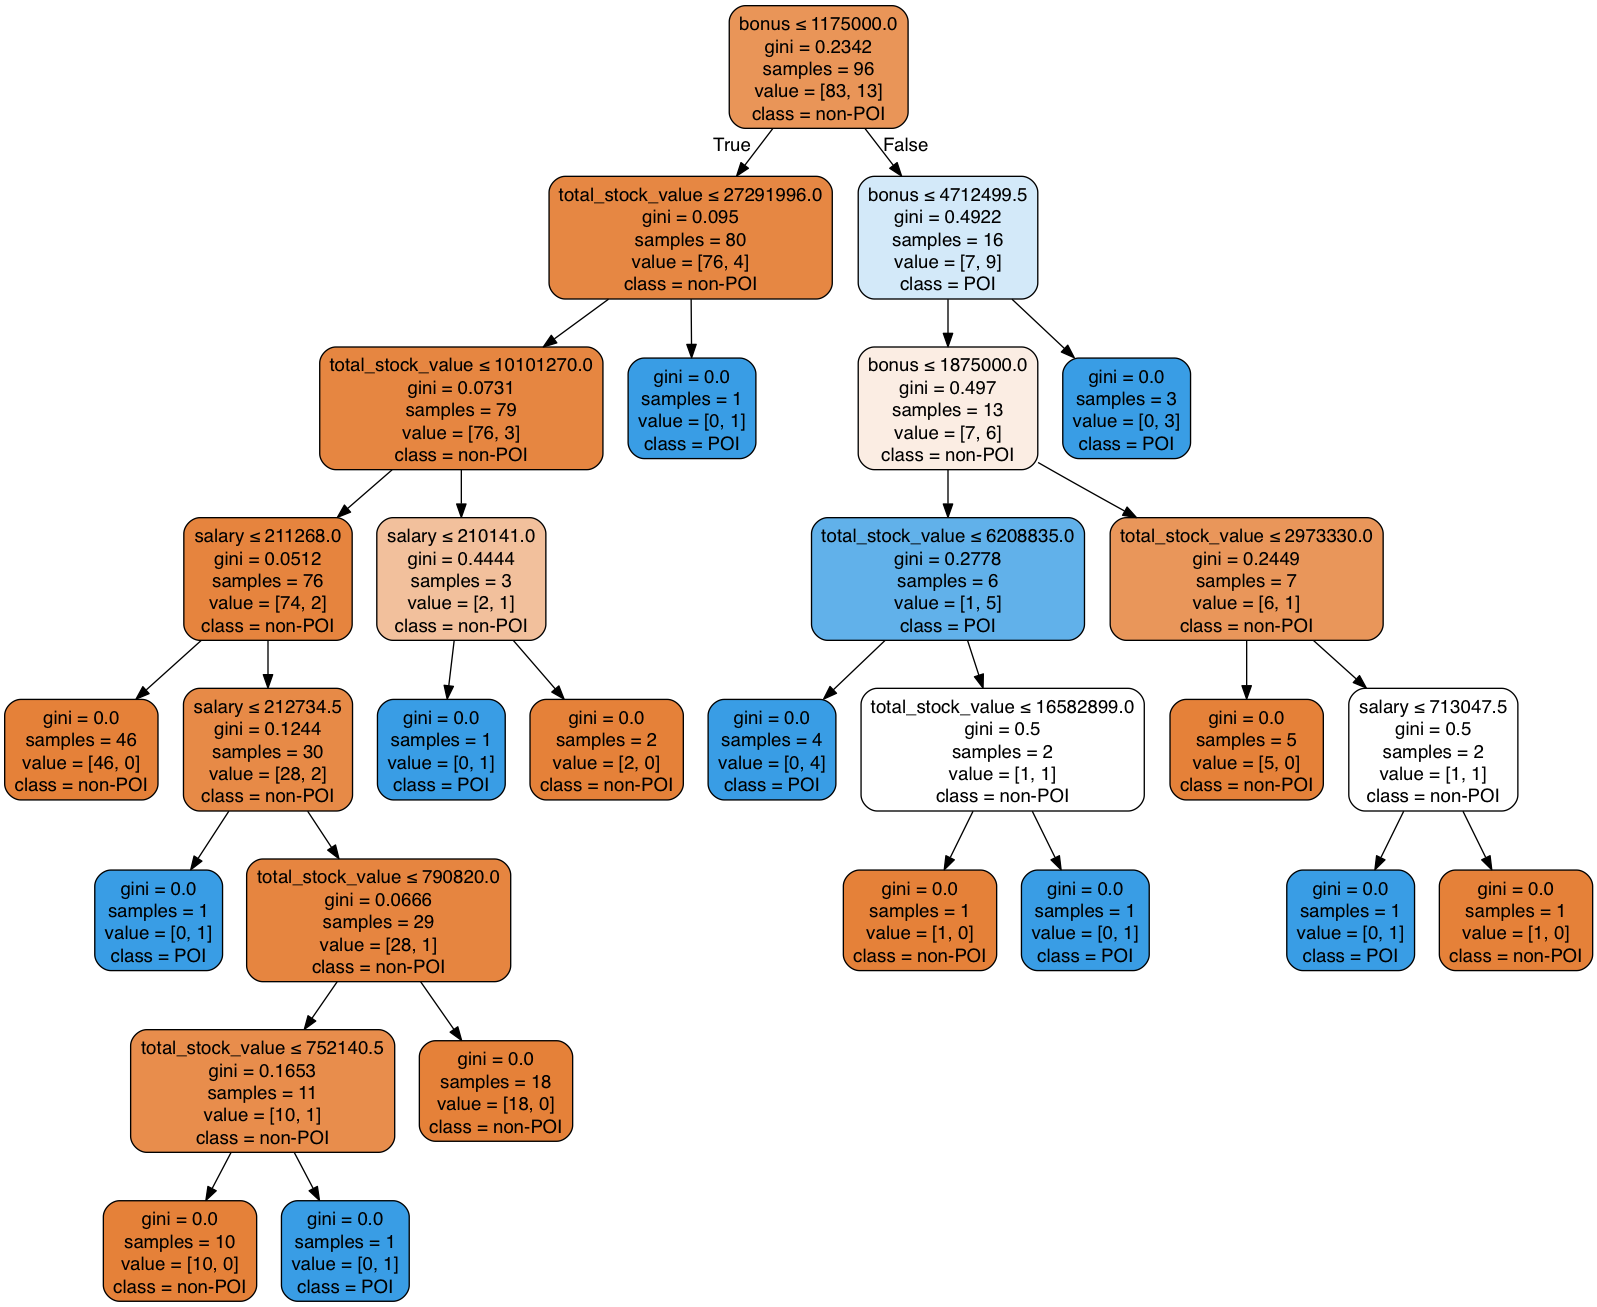

In [40]:
import pydotplus
from IPython.display import Image  

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, stratify=labels)
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=features_list[1:],  
    class_names=['non-POI', 'POI'],  
    filled=True, rounded=True,  
    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


And, now, with my new feature added back...

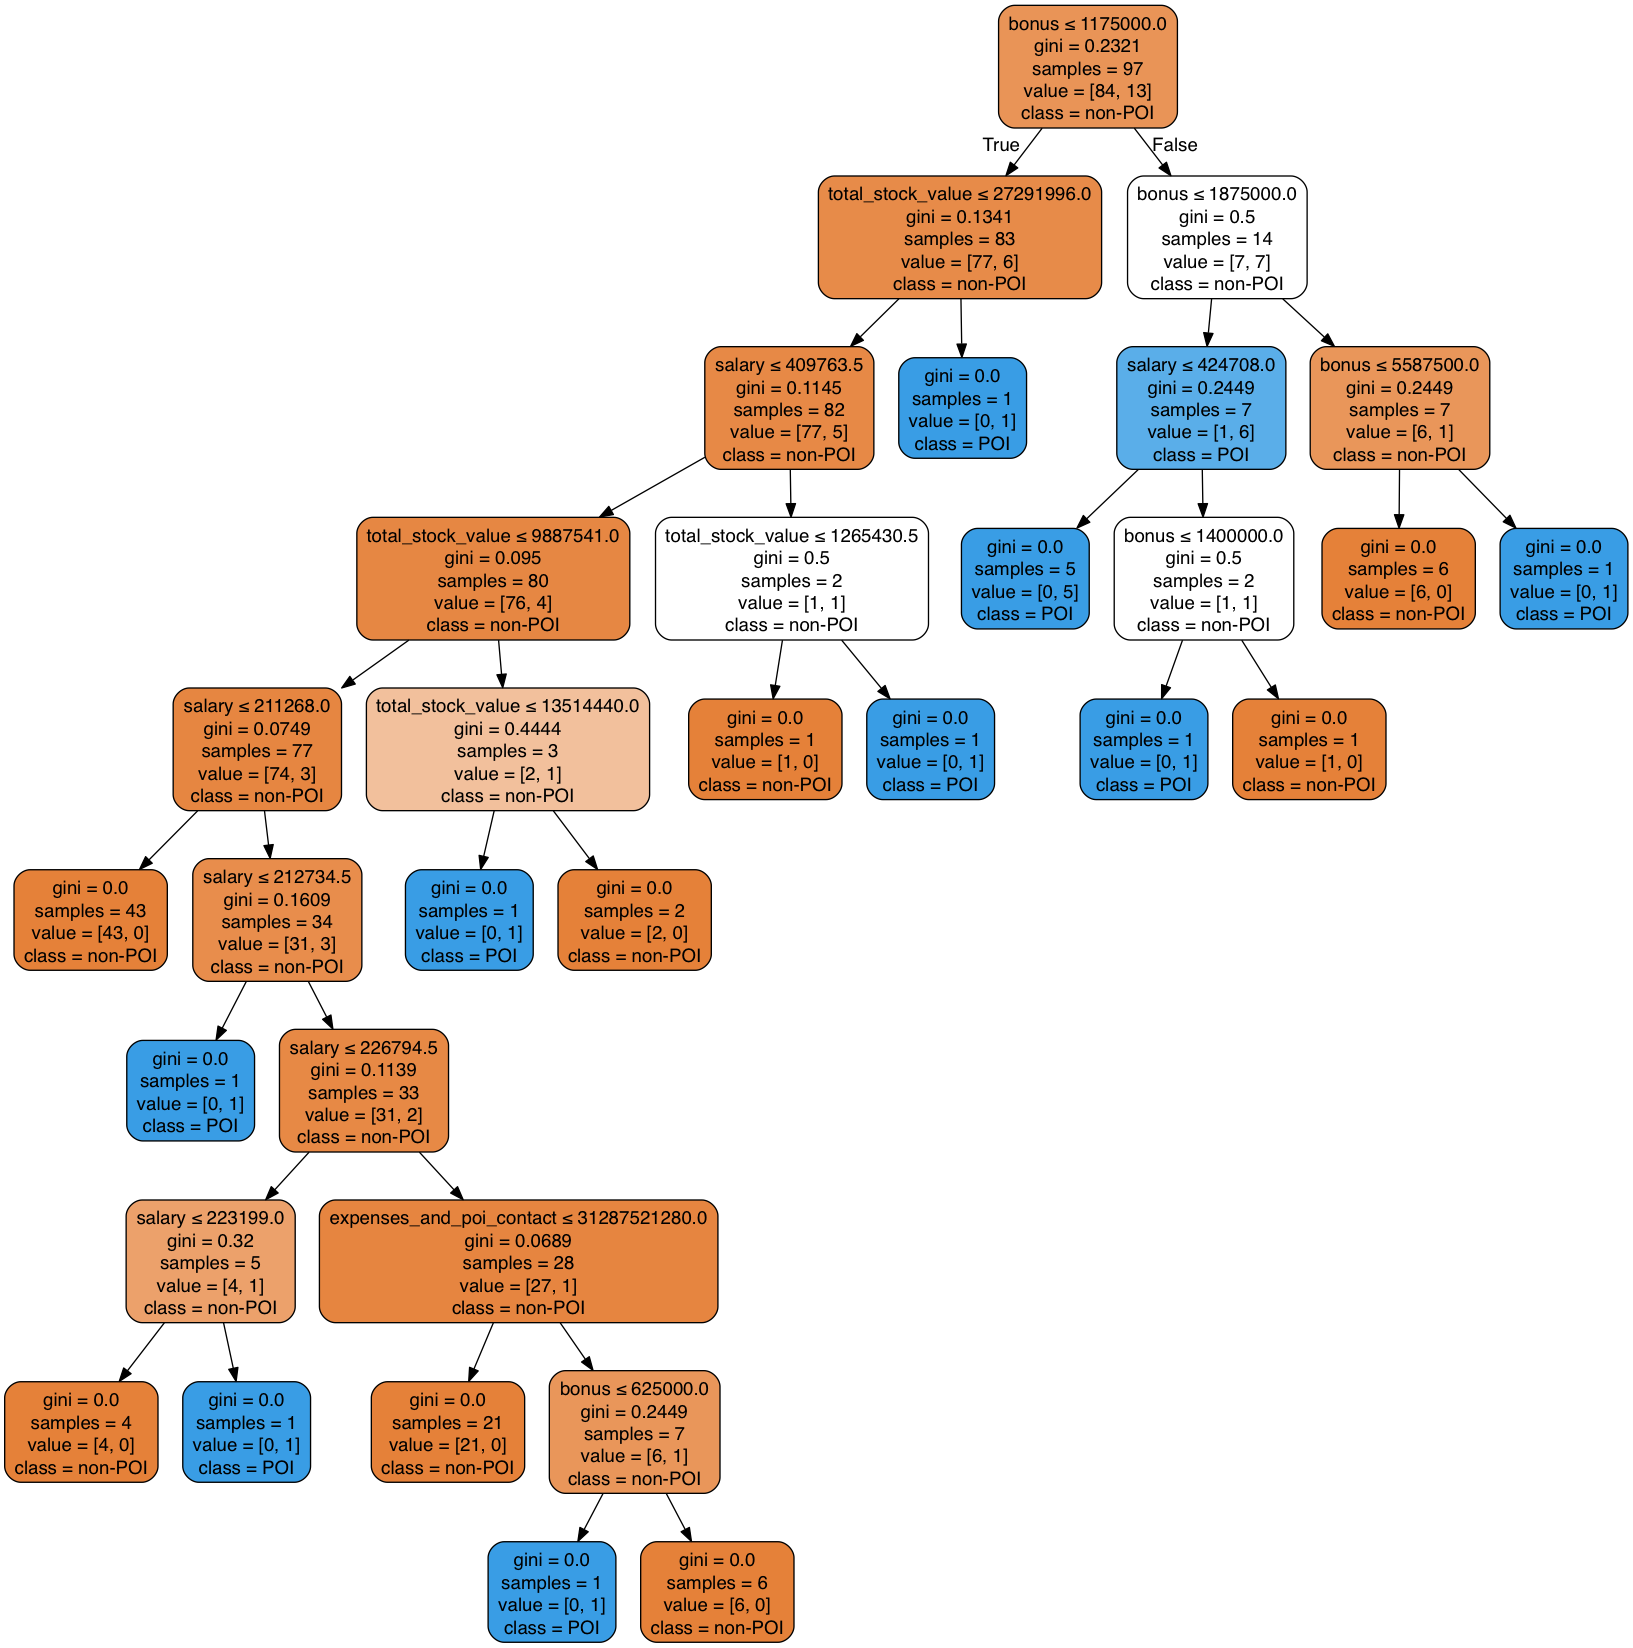

In [41]:
features_list.append('expenses_and_poi_contact')
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, stratify=labels)
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=features_list[1:],  
    class_names=['non-POI', 'POI'],  
    filled=True, rounded=True,  
    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


And we see that, near the bottom of the tree, my new feature is being used to filter out a significant number (21) of non-POIs from the *training* set. This is, probably, helping to prevent some of the false positives in the *test* set, which are otherwise lowering the precision score. And that's why including this new feature improves precision.

[Back to contents](#contents)

## Final Questions <a name="final_questions"/>

There're two final questions I'd like to address, before concluding:

### Questions

1. Why the difference in scoring, between my grid testing of the 4 possible combinations of the *criterion* and *splitter* parameters of the decision tree classifier and the tester provided, as part of the class code suite, in *final_project/tester.py*?
2. What about this John Lavorato character?

### Answers

1. It looks like the scoring difference is attributable to the fact that the simple grid testing, here, splits the scoring between labels '0' and '1', while the code in *final_projects/tester.py* does not. Instead, it tallies:
  - true positives,
  - false positives,
  - true negatives, and
  - false negatives,

 over 1,000 trials and reports the average *recall* and *precision* accordingly.

2. Searching the Web for information about John Lavorato yielded several articles, which essentially tell the same story: several Enron executives, particularly those working in the trading division, were paid huge retention bonuses, just before the bankruptcy was declared. However, nothing really alludes to anything sinister, or suggests that, perhaps, John really should've been a POI. Perhaps, we'll never know the truth of John's involvement, or lack thereof, in the fraud that was committed. One thing I'm curious about: if John's *poi* feature is changed to '1', does my classifier perform any better? Let's find out...


In [42]:
data_dict['LAVORATO JOHN J']['poi'] = 1
test_classifier(clf, data_dict, features_list)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.81785	Precision: 0.41128	Recall: 0.42650	F1: 0.41875	F2: 0.42337
	Total predictions: 13000	True positives:  853	False positives: 1221	False negatives: 1147	True negatives: 9779



Wow! Look at that. In this case, our intuition is much more resonant with the classifier's behavior. That is, we aren't the only one's to whom it seems that John ought to be a POI. Interesting.

Now, one final sanity check to make sure I haven't fallen off track somewhere, before concluding...

In [43]:
data_dict['LAVORATO JOHN J']['poi'] = 0
test_classifier(clf, data_dict, features_list)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.78569	Precision: 0.31232	Recall: 0.32700	F1: 0.31949	F2: 0.32395
	Total predictions: 13000	True positives:  654	False positives: 1440	False negatives: 1346	True negatives: 9560



Okay, great, with John's *poi* feature restored to its correct value, '0', both the *precision* and *recall* scores are what we first saw, above. And, that's a wrap.

[Back to contents](#contents)

## Conclusion <a name="conclusion"/>

I've been able to meet the final project criteria: both *recall* and *precision* >0.3, by adding a new composite feature: *expenses_and_poi_contact*, formed by taking the product of the following existing features:

- shared_receipt_with_poi
- expenses
- from_this_person_to_poi
- from_poi_to_this_person

, only after ensuring that no two of them were *correlated*, since creating a new feature by multiplying together two existing and correlated features doesn't add any new information.

In preliminary testing, I found that my new feature ranked quite high in relative feature importance. And, in fact, without it I cannot pass the criteria, above.

My first attempts at visualizing the contribution of my new feature, using feature pair scatter plots, were disappointing. And it was only after generating the decision tree diagrams, above, that I was able to see where and how my new feature was elevating the precision score of my new classifier.

This was great fun. Thanks!


[Back to contents](#contents)